# Benchmark results reporting

## Setup

### Prerequirements
This notebook requires a kernel running Python 3.5+.
You can skip this section if the kernel is already configured.

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn

### Imports and selection of the results directory

In [1]:
import functools as ft
import pandas as pd
import numpy as np
import matplotlib as mp
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')

In [2]:
results_dir = "./stable"
import os
print("current working dir: {}".format(os.getcwd()))
try:
    os.chdir(results_dir)
except:
    pass
os.getcwd()

current working dir: /Users/seb/repos/ml/automlbenchmark


'/Users/seb/repos/ml/automlbenchmark/stable'

## Results

Loading results, formatting and adding columns:
- `result` is the raw result metric computed from predictions at the end the benchmark.
    For classification problems, it is usually `auc` for binomial classification and `logloss` for multinomial classification.
- `error` ensures a standard comparison between tasks: lower is always better.
- `norm_error` is a normalization of `error` on a `[0, 1]` scale, due to `logloss` especially that can take any positive value.

In [32]:
def err(row):
    return 1 - row.result if row.result in [row.auc, row.acc]\
           else row.result
    
def norm_err(row):
    return 1 - row.result if row.result in [row.auc, row.acc]\
           else row.result / (1+row.result)

all_results = pd.read_csv('results.csv')\
                .replace('constantpredictor_enc', 'constantpredictor')
all_results.task = all_results.task.str.lower()
all_results.framework = all_results.framework.str.lower()
all_results.fold = all_results.fold.apply(int)
# all_results['error'] = 1 - all_results['acc']
all_results['error'] = [err(row) for _, row in all_results.iterrows()]
all_results['norm_error'] = [norm_err(row) for _, row in all_results.iterrows()]

all_frameworks = all_results.framework.unique()
all_tasks = all_results.task.unique()
all_folds = all_results.fold.unique()
sorted_ints = lambda arr: sorted(list(map(int, arr[~np.isnan(arr)])))

### Completed tasks/folds

In [33]:
done = all_results.groupby(['task', 'framework'])['fold'].unique()
done

task               framework        
adult              autosklearn          [0, 1, 2, 3, 4, 6, 5, 7, 8, 9]
                   autoweka             [2, 3, 1, 8, 6, 5, 0, 4, 7, 9]
                   constantpredictor    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   h2oautoml            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   oboe                 [0, 1, 2, 3, 5, 4, 6, 7, 8, 9]
                   randomforest         [0, 3, 2, 5, 4, 1, 6, 7, 8, 9]
                   tpot                 [0, 1, 3, 2, 5, 4, 6, 7, 8, 9]
australian         autosklearn          [0, 4, 2, 6, 1, 3, 5, 8, 7, 9]
                   autoweka             [1, 0, 4, 9, 2, 6, 5, 7, 3, 8]
                   constantpredictor    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   h2oautoml            [4, 0, 1, 2, 5, 3, 7, 9, 6, 8]
                   oboe                          [0, 1, 3, 9, 5, 7, 8]
                   randomforest         [0, 1, 5, 2, 3, 7, 4, 6, 8, 9]
                   tpot                 

### Missing or crashed/aborted tasks/folds

In [34]:
nfolds = 10
not_done = pd.DataFrame([(task, framework) for task in all_tasks 
                                           for framework in all_frameworks 
                                           if (task, framework) not in done.index],
                        columns=['task', 'framework'])
missing = all_results.append(not_done).groupby(['task', 'framework'])['fold']\
                     .unique()\
                     .map(sorted_ints)\
                     .map(lambda arr: sorted(list(set(range(0, nfolds)) - set(arr))))\
                     .where(lambda values: values.map(lambda arr: len(arr) > 0))\
                     .dropna()
missing

task           framework   
australian     oboe                                 [2, 4, 6]
cnae-9         autosklearn                                [9]
connect-4      tpot                                       [6]
dresses-sales  autosklearn                                [5]
eucalyptus     autosklearn                                [8]
fabert         tpot                                       [5]
helena         autosklearn     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
               randomforest                            [0, 7]
               tpot            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
mfeat-factors  autoweka                                   [9]
Name: fold, dtype: object

### Failing tasks/folds

In [35]:
failed = all_results.where(np.isnan(all_results.result))\
                    .groupby(['task', 'framework'])['fold']\
                    .unique()\
                    .map(sorted_ints)
failed

task               framework   
adult              h2oautoml                                  [9]
                   oboe            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
australian         autosklearn                                [7]
blood-transfusion  oboe                                 [2, 5, 8]
connect-4          oboe            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
credit-g           oboe                                 [1, 2, 9]
dilbert            tpot            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fabert             autosklearn                                [0]
                   oboe            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
helena             autoweka                                   [8]
                   oboe            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   randomforest          [1, 2, 3, 4, 5, 6, 8, 9]
jannis             oboe            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
kc1                autosklearn                          [5, 8, 9]
                   h2oautoml       [0, 1, 2,

## Data reports

### Results summary

Averaging using arithmetic mean over fold `result` or `error`.

In [36]:
res = all_results.groupby(['task', 'framework'])
mean_res_df = res['result'].mean().unstack()
mean_err_df = res['error'].mean().unstack()
mean_norm_err_df = res['norm_error'].mean().unstack()

#### Results mean

In [37]:
mean_res_df

framework,autosklearn,autoweka,constantpredictor,h2oautoml,oboe,randomforest,tpot
task,,,,,,,
adult,0.928613,0.909844,0.500000,0.929435,NaN,0.909225,0.927540
australian,0.934723,0.927824,0.500000,0.940968,0.868214,0.936425,0.927466
bioresponse,0.874852,0.776805,0.500000,0.884855,0.797537,0.880761,0.872357
blood-transfusion,0.748125,0.730111,0.500000,0.755699,0.632930,0.685707,0.722555
car,0.011823,0.165502,0.835786,0.006518,0.100171,0.143131,0.000807
christine,0.800113,0.778832,0.500000,0.822857,0.737905,0.805170,0.812755
cnae-9,0.203544,0.567893,2.197220,0.161331,1.886840,0.300803,0.208385
connect-4,0.469392,0.740007,0.844561,0.421447,NaN,0.494150,0.368751
credit-g,0.778334,0.753691,0.500000,0.794667,0.678431,0.793798,0.775381


#### Error mean

In [38]:
mean_err_df

framework,autosklearn,autoweka,constantpredictor,h2oautoml,oboe,randomforest,tpot
task,,,,,,,
adult,0.071387,0.090156,0.500000,0.070565,NaN,0.090775,0.072459
australian,0.065277,0.072176,0.500000,0.059032,0.131786,0.063575,0.072534
bioresponse,0.125148,0.223195,0.500000,0.115145,0.202463,0.119239,0.127643
blood-transfusion,0.251875,0.269889,0.500000,0.244301,0.367070,0.314293,0.277445
car,0.011823,0.165502,0.835786,0.006518,0.100171,0.143131,0.000807
christine,0.199887,0.221168,0.500000,0.177143,0.262095,0.194830,0.187245
cnae-9,0.203544,0.567893,2.197220,0.161331,1.886840,0.300803,0.208385
connect-4,0.469392,0.740007,0.844561,0.421447,NaN,0.494150,0.368751
credit-g,0.221666,0.246310,0.500000,0.205333,0.321569,0.206202,0.224619


In [39]:
mean_res_df.to_csv("result_summary.csv", float_format='%.6g')
mean_err_df.to_csv("error_summary.csv", float_format='%.6g')
mean_norm_err_df.to_csv("norm_error_summary.csv", float_format='%.6g')

### Tasks leaderboard

In [40]:
def rank(errors):
    sorted_errors = np.sort(errors.unique())
    ranks = pd.Series(index=errors.index)
    for idx, value in errors.items():
        try:
            ranks.at[idx] = np.where(sorted_errors == value)[0][0] + 1
        except IndexError:
            ranks.at[idx] = np.nan
    return ranks

In [41]:
task_leaderboard_df = mean_err_df.apply(rank, axis=1, result_type='broadcast').astype(object)
task_leaderboard_df.astype(float).to_csv('tasks_leaderboard.csv', float_format='%.f')
task_leaderboard_df

framework,autosklearn,autoweka,constantpredictor,h2oautoml,oboe,randomforest,tpot
task,,,,,,,
adult,2,4,6,1,NaN,5,3
australian,3,4,7,1,6,2,5
bioresponse,3,6,7,1,5,2,4
blood-transfusion,2,3,7,1,6,5,4
car,3,6,7,2,4,5,1
christine,4,5,7,1,6,3,2
cnae-9,2,5,7,1,6,4,3
connect-4,3,5,6,2,NaN,4,1
credit-g,3,5,7,1,6,2,4


### Folds leaderboard

In [42]:
folds_err_df = all_results.pivot_table(index=['task', 'fold'], columns='framework', values='error')
folds_leaderboard_df = folds_err_df.apply(rank, axis=1, result_type='broadcast').astype(object)
folds_leaderboard_df.astype(float).to_csv('folds_leaderboard.csv', float_format='%.f')
folds_leaderboard_df

framework        autosklearn autoweka constantpredictor h2oautoml oboe  \
task        fold                                                         
adult       0              1        5                 6         2  NaN   
            1              2        4                 6         1  NaN   
            2              2        5                 6         1  NaN   
            3              3        4                 6         1  NaN   
            4              2        5                 6         1  NaN   
            5              2        5                 6         1  NaN   
            6              2        4                 6         1  NaN   
            7              1        4                 6         2  NaN   
            8              2        4                 6         1  NaN   
            9              2        3                 5       NaN  NaN   
australian  0              1        4                 7         3    6   
            1              1        4                 6         2    5   
            2              3        1                 6         2  NaN   
            3              5        2                 7         3    6   
            4              4        1                 6         2  NaN   
            5              2        4                 6         2    5   
            6              3        5                 6         1  NaN   
            7            NaN        4                 6         1    5   
            8              5        1                 7         2    6   
            9              2        4                 7         3    6   
bioresponse 0              1        6                 7         3    5   
            1              4        6                 7         1    5   
            2              4        5                 7         1    6   
            3              3        6                 7         1    5   
            4              4        6                 7         1    5   
            5              4        5                 7         1    6   
            6              3        6                 7         1    5   
            7              4        6                 7         1    5   
            8              3        6                 7         1    5   
            9              3        6                 7         1    5   
...                      ...      ...               ...       ...  ...   
segment     0              1        5                 7         2    6   
            1              3        5                 7         2    6   
            2              3        5                 7         1    6   
            3              2        5                 6         3    7   
            4              3        4                 7         2    6   
            5              2        5                 7         1    6   
            6              2        5                 7         3    6   
            7              4        5                 7         1    6   
            8              3        6                 7         1    5   
            9              2        6                 7         1    5   
sylvine     0              1        5                 7         3    6   
            1              1        4                 6         3    5   
            2              2        5                 7         1    6   
            3              3        5                 7         2    6   
            4              1        5                 7         3    6   
            5              1        5                 7         3    6   
            6              3        5                 7         2    6   
            7              2        5                 7         3    6   
            8              3        5                 7         2    6   
            9              3        5                 7         1    6   
vehicle     0              3        7                 5         1    6   
    

## Visualizations

In [43]:
def savefig(fig, path):
    fig.savefig(path, bbox_inches='tight')
    
def draw_heatmap(df):
    sb.set(style="whitegrid")
    hm = sb.heatmap(df, yticklabels=df.index, annot=True, cmap='YlOrBr')
    hm.figure.set_size_inches(8, 8)
    hm.figure.set_dpi(120)
    return hm.figure

def draw_parallel_coord(df, class_column, yscale='linear'):
    parallel_fig = mp.pyplot.figure(dpi=120, figsize=(10, 8))
    mp.pyplot.xticks(rotation=90)
    mp.pyplot.yscale(yscale)
    axes = pd.plotting.parallel_coordinates(df, class_column=class_column, colormap='tab10')
#     axes.set_yscale('log')
#     axes.tick_params(axis='x', labelrotation=90) 
    return parallel_fig

def draw_stripplot(df, x, y, hue, xscale='linear', xbound=None, legend_loc='best'):
    sb.set(style="whitegrid")

    # Initialize the figure
    strip_fig, axes = mp.pyplot.subplots(dpi=120, figsize=(8, 12))
    axes.set_xscale(xscale)
    if xbound is not None:   
        axes.set_autoscalex_on(False)
        axes.set_xbound(*xbound)
#     axes.invert_xaxis()
    sb.despine(bottom=True, left=True)

    # Show each observation with a scatterplot
    sb.stripplot(x=x, y=y, hue=hue,
                 data=df, dodge=True, jitter=True,
                 alpha=.25, zorder=1)

    # Show the conditional means
    sb.pointplot(x=x, y=y, hue=hue,
                 data=df, dodge=.5, join=False, palette="tab10",
                 markers="d", scale=.75, ci=None)

    # Improve the legend 
    handles, labels = axes.get_legend_handles_labels()
    dist = int(len(labels)/2)
    axes.legend(handles[dist:], labels[dist:], title=hue,
                handletextpad=0, columnspacing=1,
                loc=legend_loc, ncol=1, frameon=True)
    return strip_fig

### Heatmaps

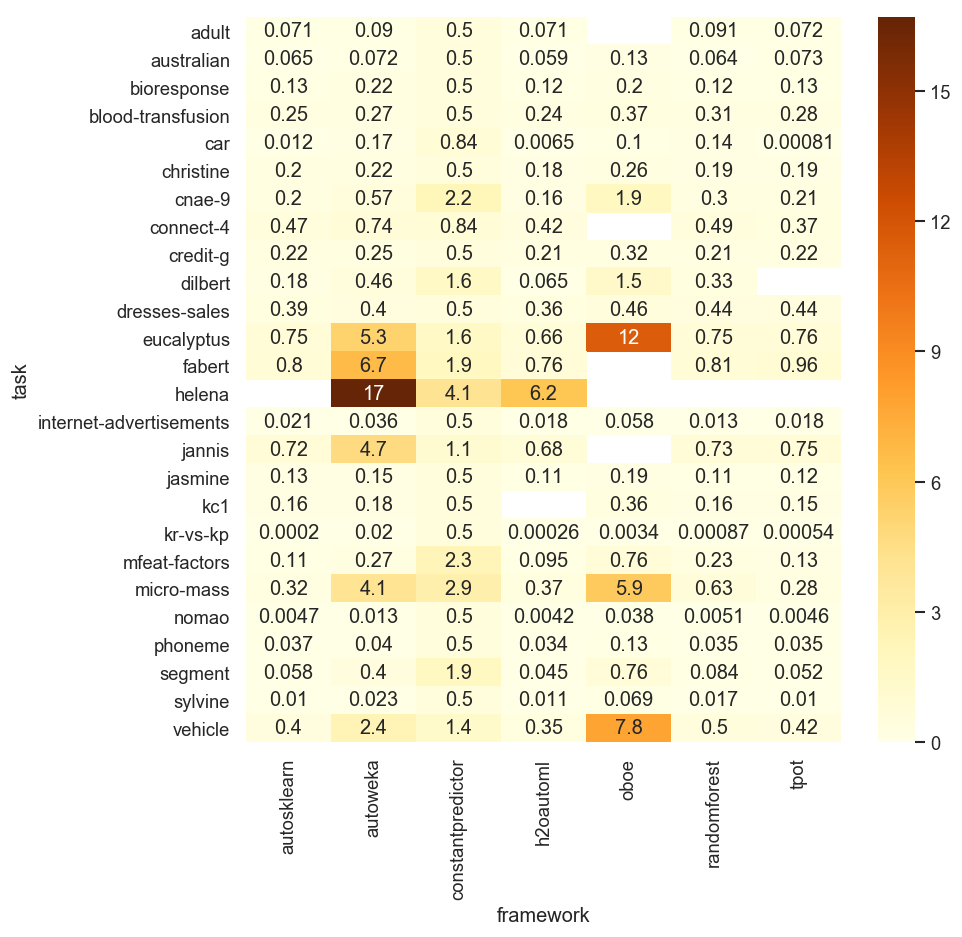

In [44]:
heat_err_fig = draw_heatmap(mean_err_df)

In [45]:
savefig(heat_err_fig, "heat_error.png")

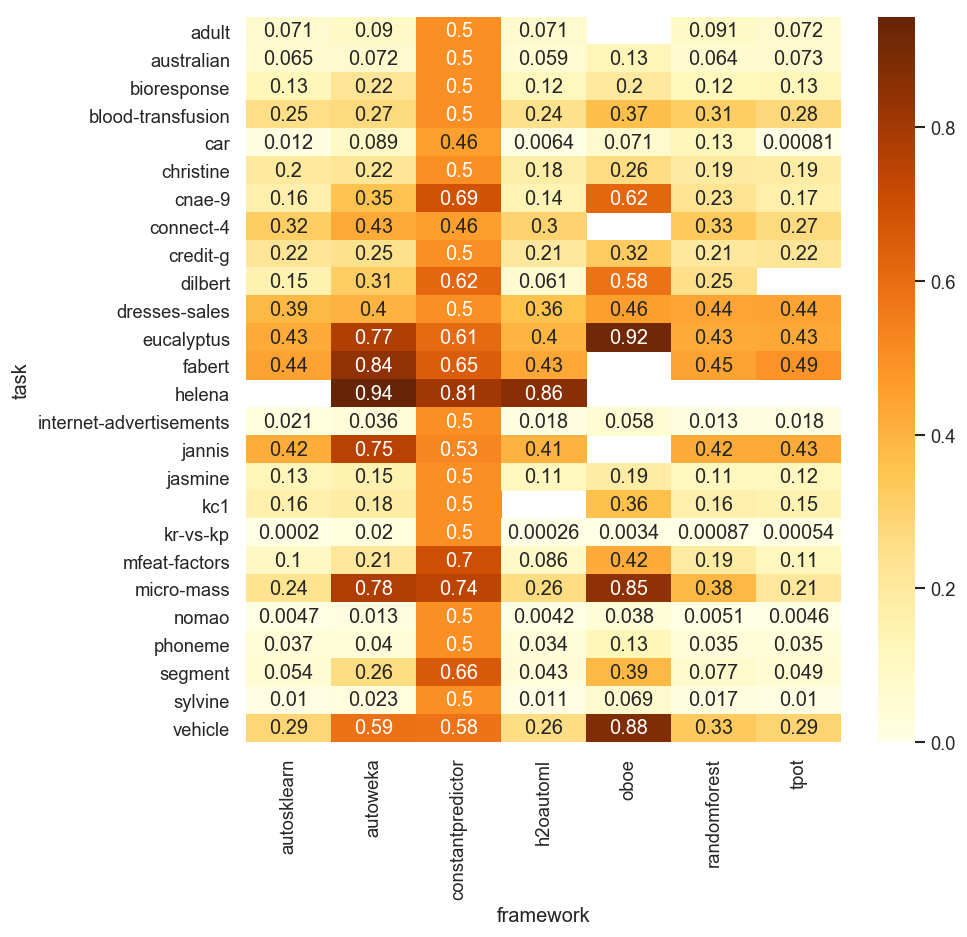

In [46]:
heat_norm_err_fig = draw_heatmap(mean_norm_err_df)

In [47]:
savefig(heat_norm_err_fig, "heat_norm_error.png")

### Linear plots

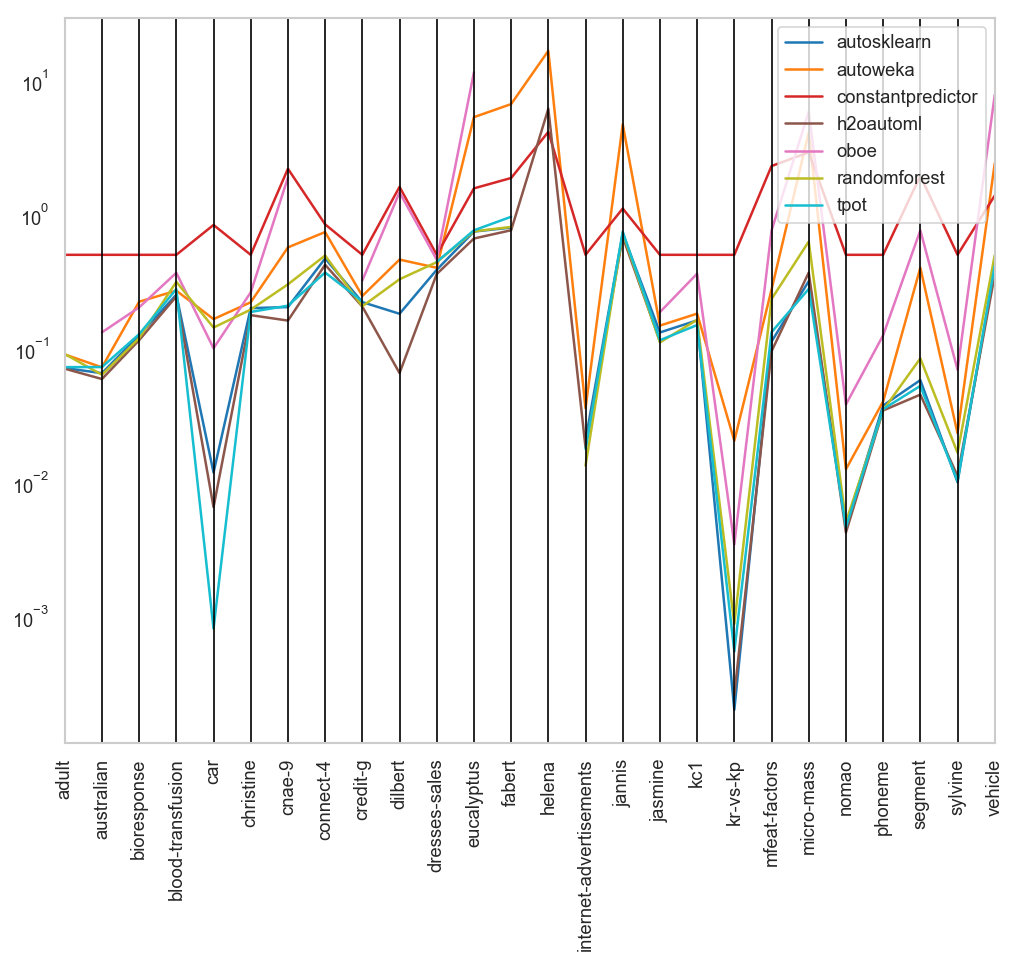

In [48]:
mean_err_parallel_df = res['error'].mean().unstack(level=0)
mean_err_parallel_df.reset_index(inplace=True)
parallel_err_log_fig = draw_parallel_coord(mean_err_parallel_df, 'framework', yscale='log')

In [49]:
savefig(parallel_err_log_fig, "parallel_coordinates_error_log.png")

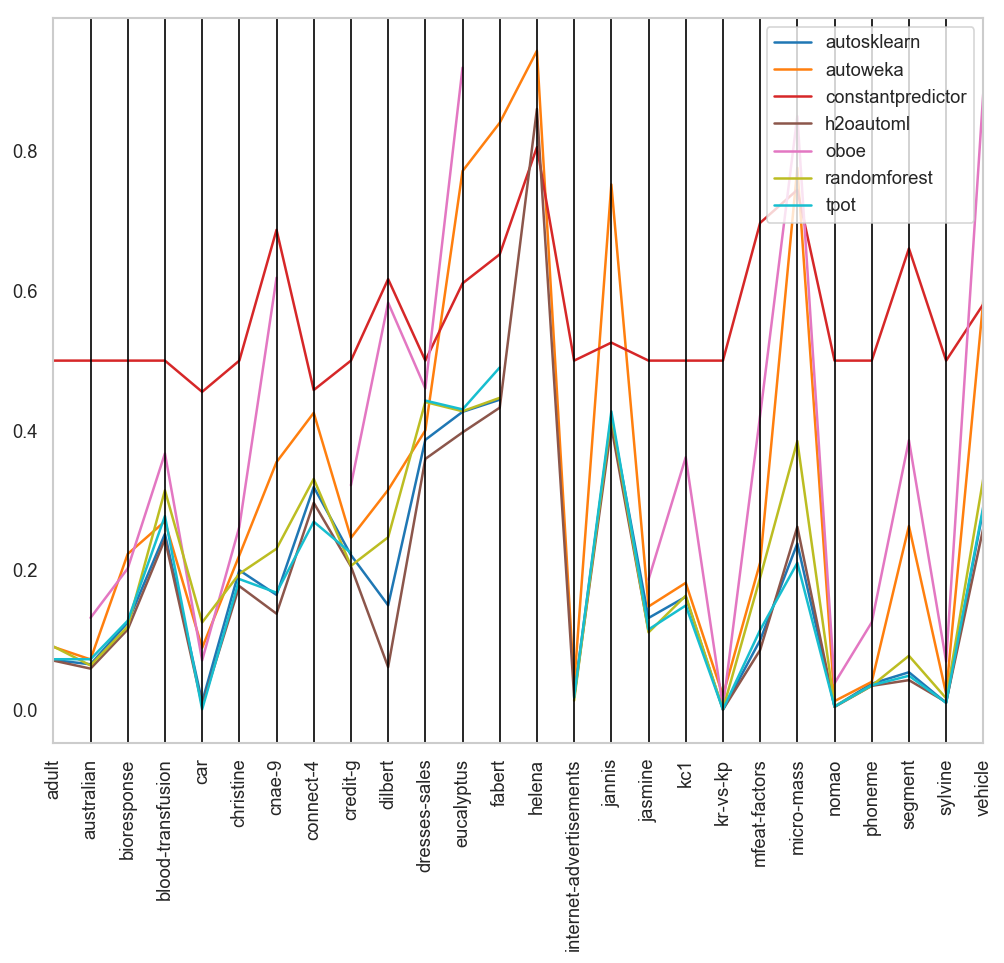

In [50]:
mean_norm_err_parallel_df = res['norm_error'].mean().unstack(level=0)
mean_norm_err_parallel_df.reset_index(inplace=True)
parallel_norm_err_fig = draw_parallel_coord(mean_norm_err_parallel_df, 'framework')

### Scatterplots

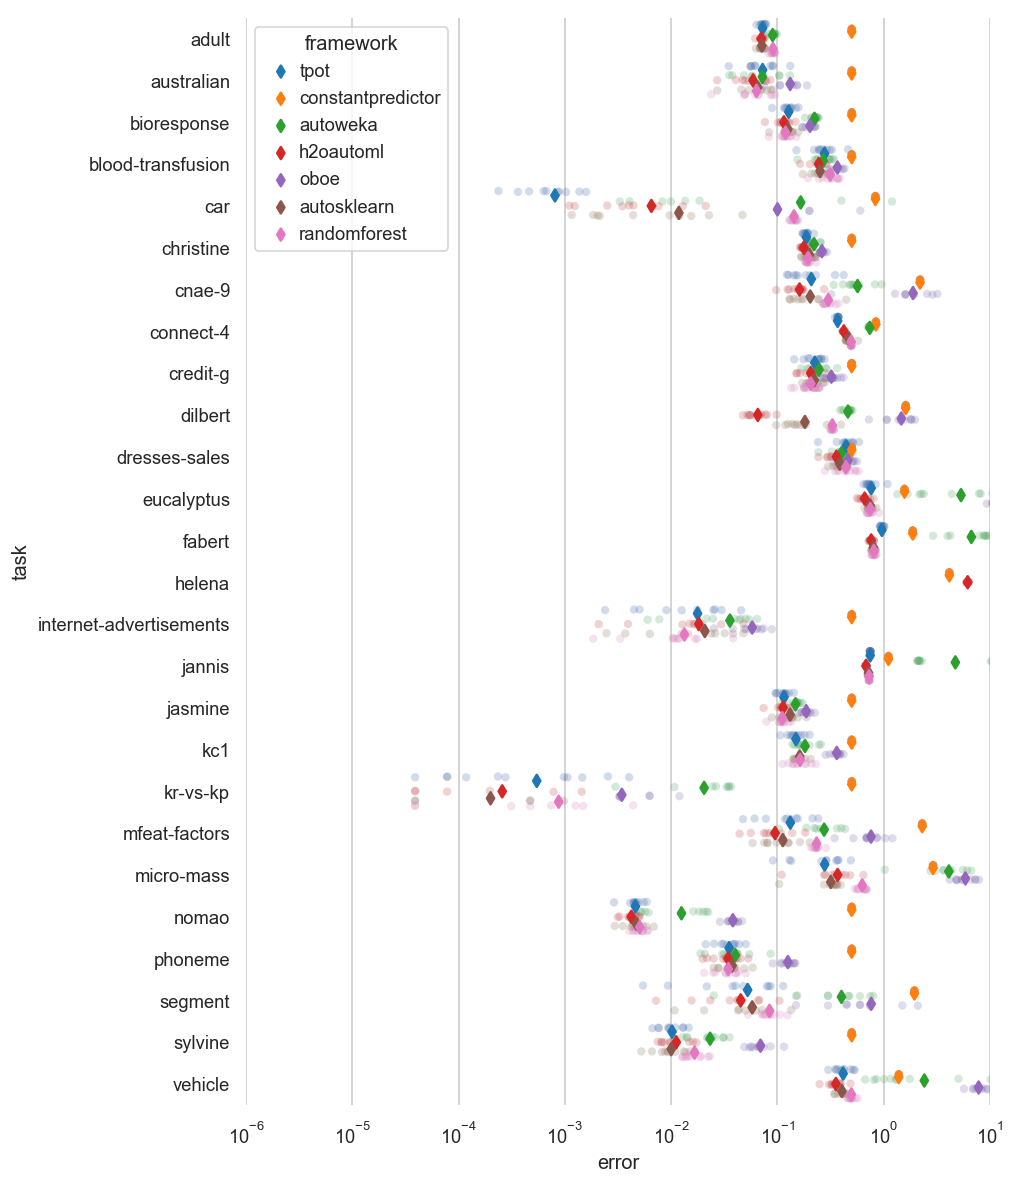

In [51]:
strip_err_log_fig = draw_stripplot(
    all_results.sort_values(by='task'),
    x='error',
    y='task',
    hue='framework',
    xscale='log',
    xbound=(1e-6, 10),
    legend_loc='bottom left'
)

In [52]:
savefig(strip_err_log_fig, "stripplot_error_log.png")

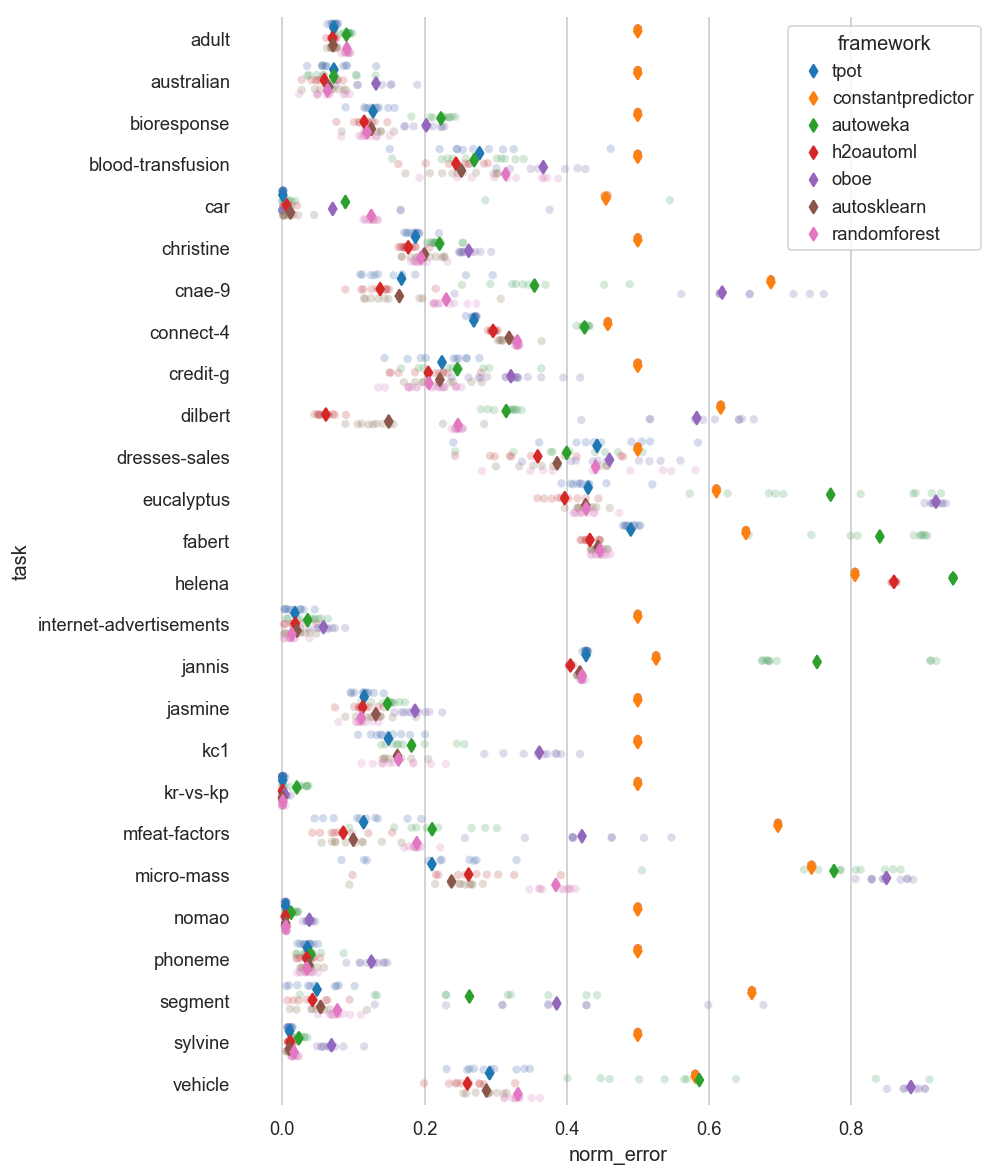

In [53]:
strip_norm_err_fig = draw_stripplot(
    all_results.sort_values(by='task'),
    x='norm_error',
    y='task',
    hue='framework',
#     xscale='symlog',
    legend_loc='upper right'
)

In [54]:
savefig(strip_norm_err_fig, "stripplot_norm_error.png")

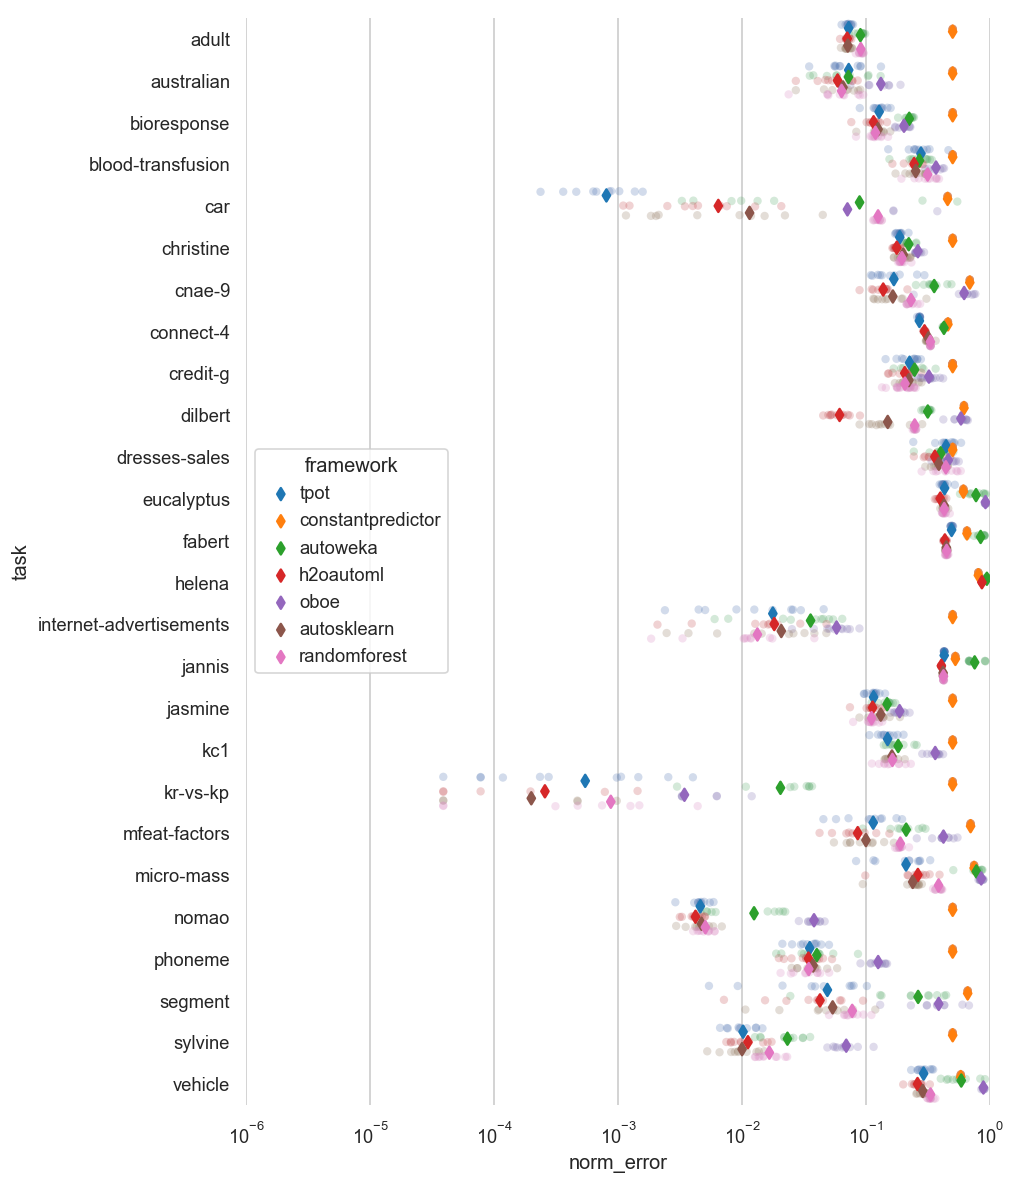

In [55]:
strip_norm_err_log_fig = draw_stripplot(
    all_results.sort_values(by='task'),
    x='norm_error',
    y='task',
    hue='framework',
#     xscale='logit',
    xscale='log',
    xbound=(1e-6, 1),
    legend_loc='center left'
)

In [56]:
savefig(strip_norm_err_log_fig, "stripplot_norm_error_log.png")

## Playground

In [61]:
all_results.loc[(all_results.task=='jannis')&(all_results.framework=='tpot')]

,id,task,framework,fold,result,mode,version,tag,utc,duration,models,seed,info,acc,auc,logloss,error,norm_error
1085,openml.org/t/168330,jannis,tpot,0,0.730814,aws.docker,0.9.6,stable,2019-03-05T21:40:55,3746.0,64.0,3678354726,NaN,0.704801,NaN,0.730814,0.730814,0.422237
1807,openml.org/t/168330,jannis,tpot,0,0.747973,aws.docker,0.9.6,stable,2019-03-12T00:53:02,3670.5,72.0,1110989978,NaN,0.690829,NaN,0.747973,0.747973,0.427909
1808,openml.org/t/168330,jannis,tpot,1,0.745670,aws.docker,0.9.6,stable,2019-03-12T00:54:17,3718.5,72.0,1110989978,NaN,0.703487,NaN,0.745670,0.745670,0.427154
1809,openml.org/t/168330,jannis,tpot,2,0.743740,aws.docker,0.9.6,stable,2019-03-12T00:54:29,3711.6,72.0,1110989978,NaN,0.697994,NaN,0.743740,0.743740,0.426520
1810,openml.org/t/168330,jannis,tpot,3,0.740583,aws.docker,0.9.6,stable,2019-03-12T00:55:31,3692.9,72.0,1110989978,NaN,0.694972,NaN,0.740583,0.740583,0.425480
1811,openml.org/t/168330,jannis,tpot,6,0.752701,aws.docker,0.9.6,stable,2019-03-12T00:56:51,3654.2,72.0,1110989978,NaN,0.689717,NaN,0.752701,0.752701,0.429452
1812,openml.org/t/168330,jannis,tpot,5,0.747867,aws.docker,0.9.6,stable,2019-03-12T00:56:52,3661.5,72.0,1110989978,NaN,0.697122,NaN,0.747867,0.747867,0.427874
1813,openml.org/t/168330,jannis,tpot,4,0.748101,aws.docker,0.9.6,stable,2019-03-12T00:57:02,3723.4,72.0,1110989978,NaN,0.697719,NaN,0.748101,0.748101,0.427951
1814,openml.org/t/168330,jannis,tpot,7,0.750171,aws.docker,0.9.6,stable,2019-03-12T00:57:36,3680.5,72.0,1110989978,NaN,0.693897,NaN,0.750171,0.750171,0.428627
1815,openml.org/t/168330,jannis,tpot,8,0.744388,aws.docker,0.9.6,stable,2019-03-12T00:58:02,3680.6,72.0,1110989978,NaN,0.699630,NaN,0.744388,0.744388,0.426733


In [58]:
done.iloc[done.index.get_level_values('framework').isin(['autosklearn', 'h2oautoml', 'tpot'])]\
    .apply(sorted_ints);

In [65]:
failures = all_results.loc[np.isnan(all_results.result)]\
                    .groupby(['task', 'fold', 'framework'])['info']\
                    .unique()
failures

task               fold  framework   
adult              0     oboe                             [Error: list index out of range]
                   1     oboe                             [Error: list index out of range]
                   2     oboe                             [Error: list index out of range]
                   3     oboe                             [Error: list index out of range]
                   4     oboe                             [Error: list index out of range]
                   5     oboe                             [Error: list index out of range]
                   6     oboe                             [Error: list index out of range]
                   7     oboe                             [Error: list index out of range]
                   8     oboe                             [Error: list index out of range]
                   9     h2oautoml       [Error: Job with key $03017f00000132d4ffffffff...
                         oboe                       